# LibriSpeech model visualizations

In [ ]:
# load data
import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

project_root = Path.cwd().parent
sys.path.append(str(project_root))

from config.features import configs as feature_configs

with open(project_root / "results/LibriSpeech_results_mean.json", "r") as f:
    results = json.load(f)

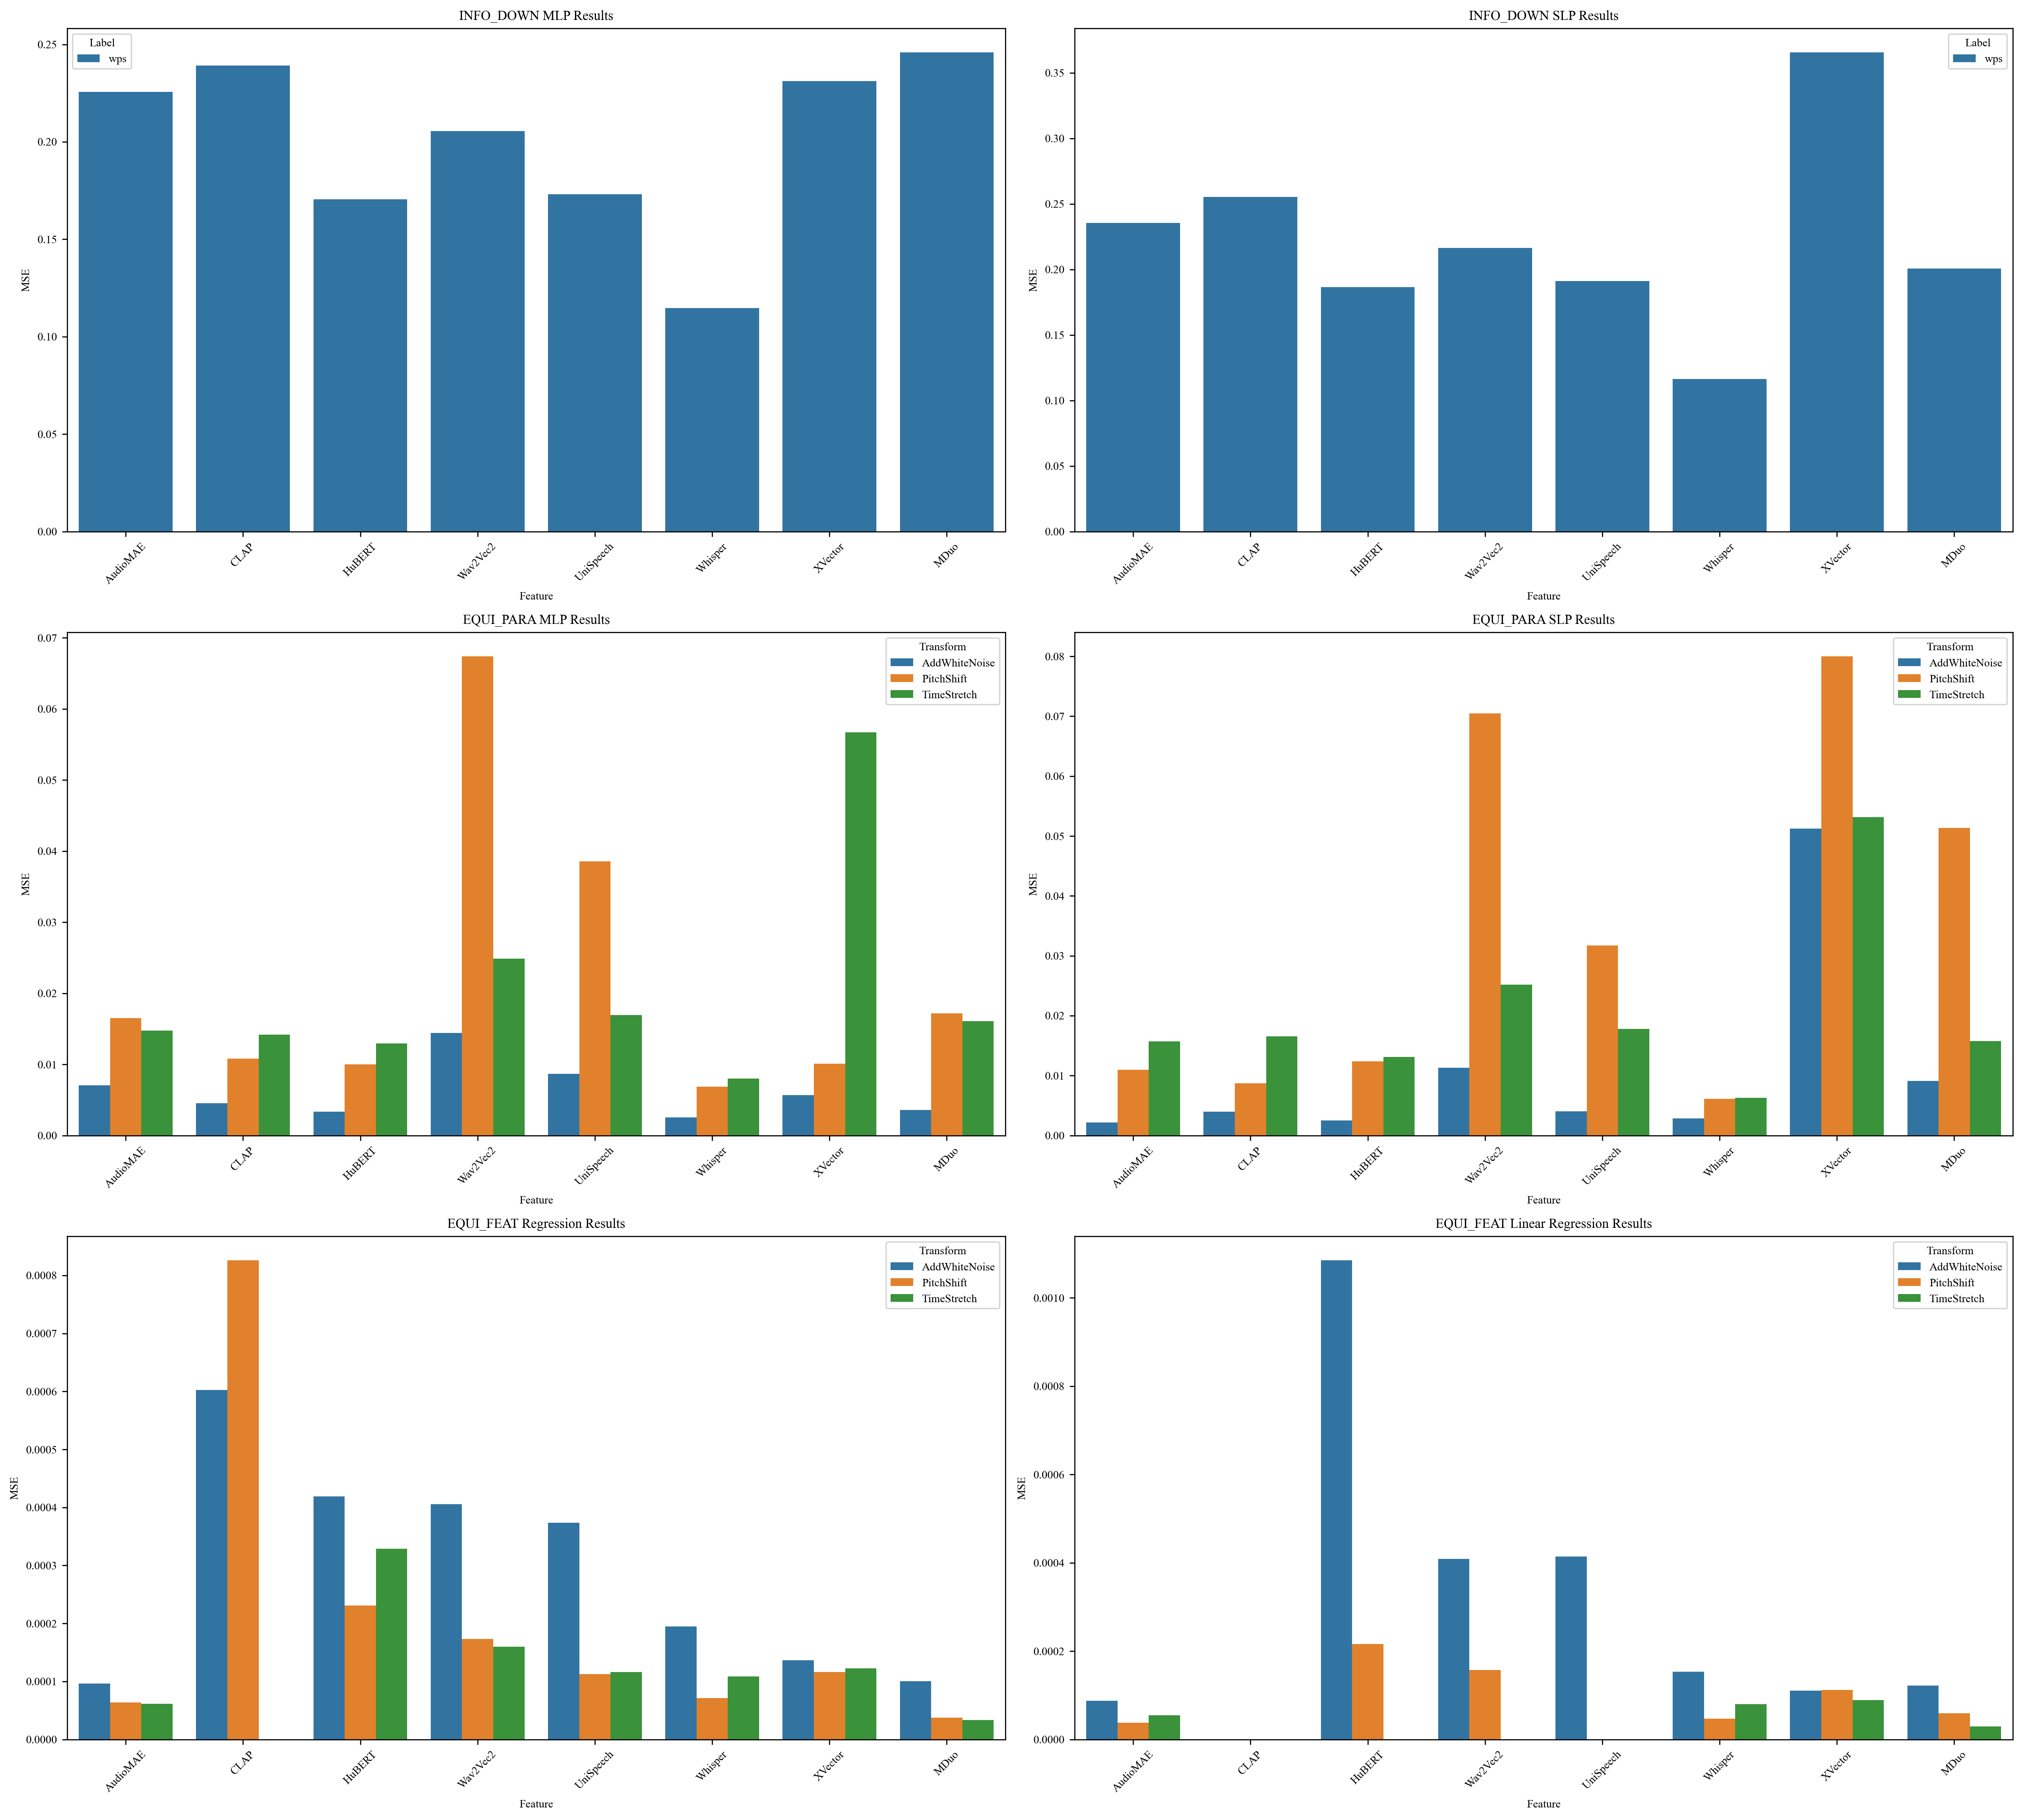

In [ ]:
# Define consistent feature order
feature_order = [
    "AudioMAE",
    "CLAP",
    "HuBERT",
    "Wav2Vec2",
    "UniSpeech",
    "Whisper",
    "XVector",
    "MDuo",
]

# Constants for normalization (placeholders)
LABEL_SCALING = {
    "wps": 1,  # Placeholder value
}
TRANSFORM_SCALING = {
    "PitchShift": 1,
    "TimeStretch": 1,
    "AddWhiteNoise": 1,
}  # Placeholder values

# Create 2x3 subplot grid
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 18))

# 1. INFO_DOWN Plots
info_data = {"linear": [], "nonlinear": []}
for run_name, metrics in results.items():
    if "INFO_DOWN_regression_" in run_name:
        feature = next((f for f in feature_order if f in run_name), None)
        label = next((l for l in ["wps"] if l in run_name), None)
        if feature and label:
            scaled_mse = metrics["mse"] / LABEL_SCALING[label]
            if "linear" in run_name:
                info_data["linear"].append(
                    {"Feature": feature, "Label": label, "MSE": scaled_mse}
                )
            else:
                info_data["nonlinear"].append(
                    {"Feature": feature, "Label": label, "MSE": scaled_mse}
                )

df_info_nonlinear = pd.DataFrame(info_data["nonlinear"])
df_info_linear = pd.DataFrame(info_data["linear"])
sns.barplot(
    data=df_info_nonlinear,
    x="Feature",
    y="MSE",
    hue="Label",
    ax=ax1,
    order=feature_order,
)
sns.barplot(
    data=df_info_linear, x="Feature", y="MSE", hue="Label", ax=ax2, order=feature_order
)
ax1.set_title("INFO_DOWN MLP Results")
ax2.set_title("INFO_DOWN SLP Results")
ax1.tick_params(axis="x", rotation=45)
ax2.tick_params(axis="x", rotation=45)

# 2. EQUI_PARA Plots
para_data = {"linear": [], "nonlinear": []}
for run_name, metrics in results.items():
    if "EQUI_PARA_regression_" in run_name:
        feature = next((f for f in feature_order if f in run_name), None)
        transform = next(
            (
                t
                for t in ["PitchShift", "TimeStretch", "AddWhiteNoise"]
                if t in run_name
            ),
            None,
        )
        if feature and transform:
            if "linear" in run_name:
                para_data["linear"].append(
                    {"Feature": feature, "Transform": transform, "MSE": metrics["mse"]}
                )
            else:
                para_data["nonlinear"].append(
                    {"Feature": feature, "Transform": transform, "MSE": metrics["mse"]}
                )

df_para_nonlinear = pd.DataFrame(para_data["nonlinear"])
df_para_linear = pd.DataFrame(para_data["linear"])
sns.barplot(
    data=df_para_nonlinear,
    x="Feature",
    y="MSE",
    hue="Transform",
    ax=ax3,
    order=feature_order,
)
sns.barplot(
    data=df_para_linear,
    x="Feature",
    y="MSE",
    hue="Transform",
    ax=ax4,
    order=feature_order,
)
ax3.set_title("EQUI_PARA MLP Results")
ax4.set_title("EQUI_PARA SLP Results")
ax3.tick_params(axis="x", rotation=45)
ax4.tick_params(axis="x", rotation=45)

# 3. EQUI_FEAT Plots
feat_data = {"linear": [], "nonlinear": []}
for run_name, metrics in results.items():
    if "EQUI_FEAT_regression_" in run_name:
        feature = next((f for f in feature_order if f in run_name), None)
        transform = next(
            (
                t
                for t in ["PitchShift", "TimeStretch", "AddWhiteNoise"]
                if t in run_name
            ),
            None,
        )
        if feature and transform:
            # Normalize MSE by feature dimension
            scaled_mse = metrics["mse"] / feature_configs[feature]["feature_dim"]
            if "linear" in run_name:
                feat_data["linear"].append(
                    {"Feature": feature, "Transform": transform, "MSE": scaled_mse}
                )
            else:
                feat_data["nonlinear"].append(
                    {"Feature": feature, "Transform": transform, "MSE": scaled_mse}
                )

df_feat_nonlinear = pd.DataFrame(feat_data["nonlinear"])
df_feat_linear = pd.DataFrame(feat_data["linear"])
sns.barplot(
    data=df_feat_nonlinear,
    x="Feature",
    y="MSE",
    hue="Transform",
    ax=ax5,
    order=feature_order,
)
sns.barplot(
    data=df_feat_linear,
    x="Feature",
    y="MSE",
    hue="Transform",
    ax=ax6,
    order=feature_order,
)
ax5.set_title("EQUI_FEAT Regression Results")
ax6.set_title("EQUI_FEAT Linear Regression Results")
ax5.tick_params(axis="x", rotation=45)
ax6.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
        "font.size": 8,
        "figure.dpi": 300,  # Set display DPI
        "savefig.dpi": 300,  # Set save DPI
    }
)

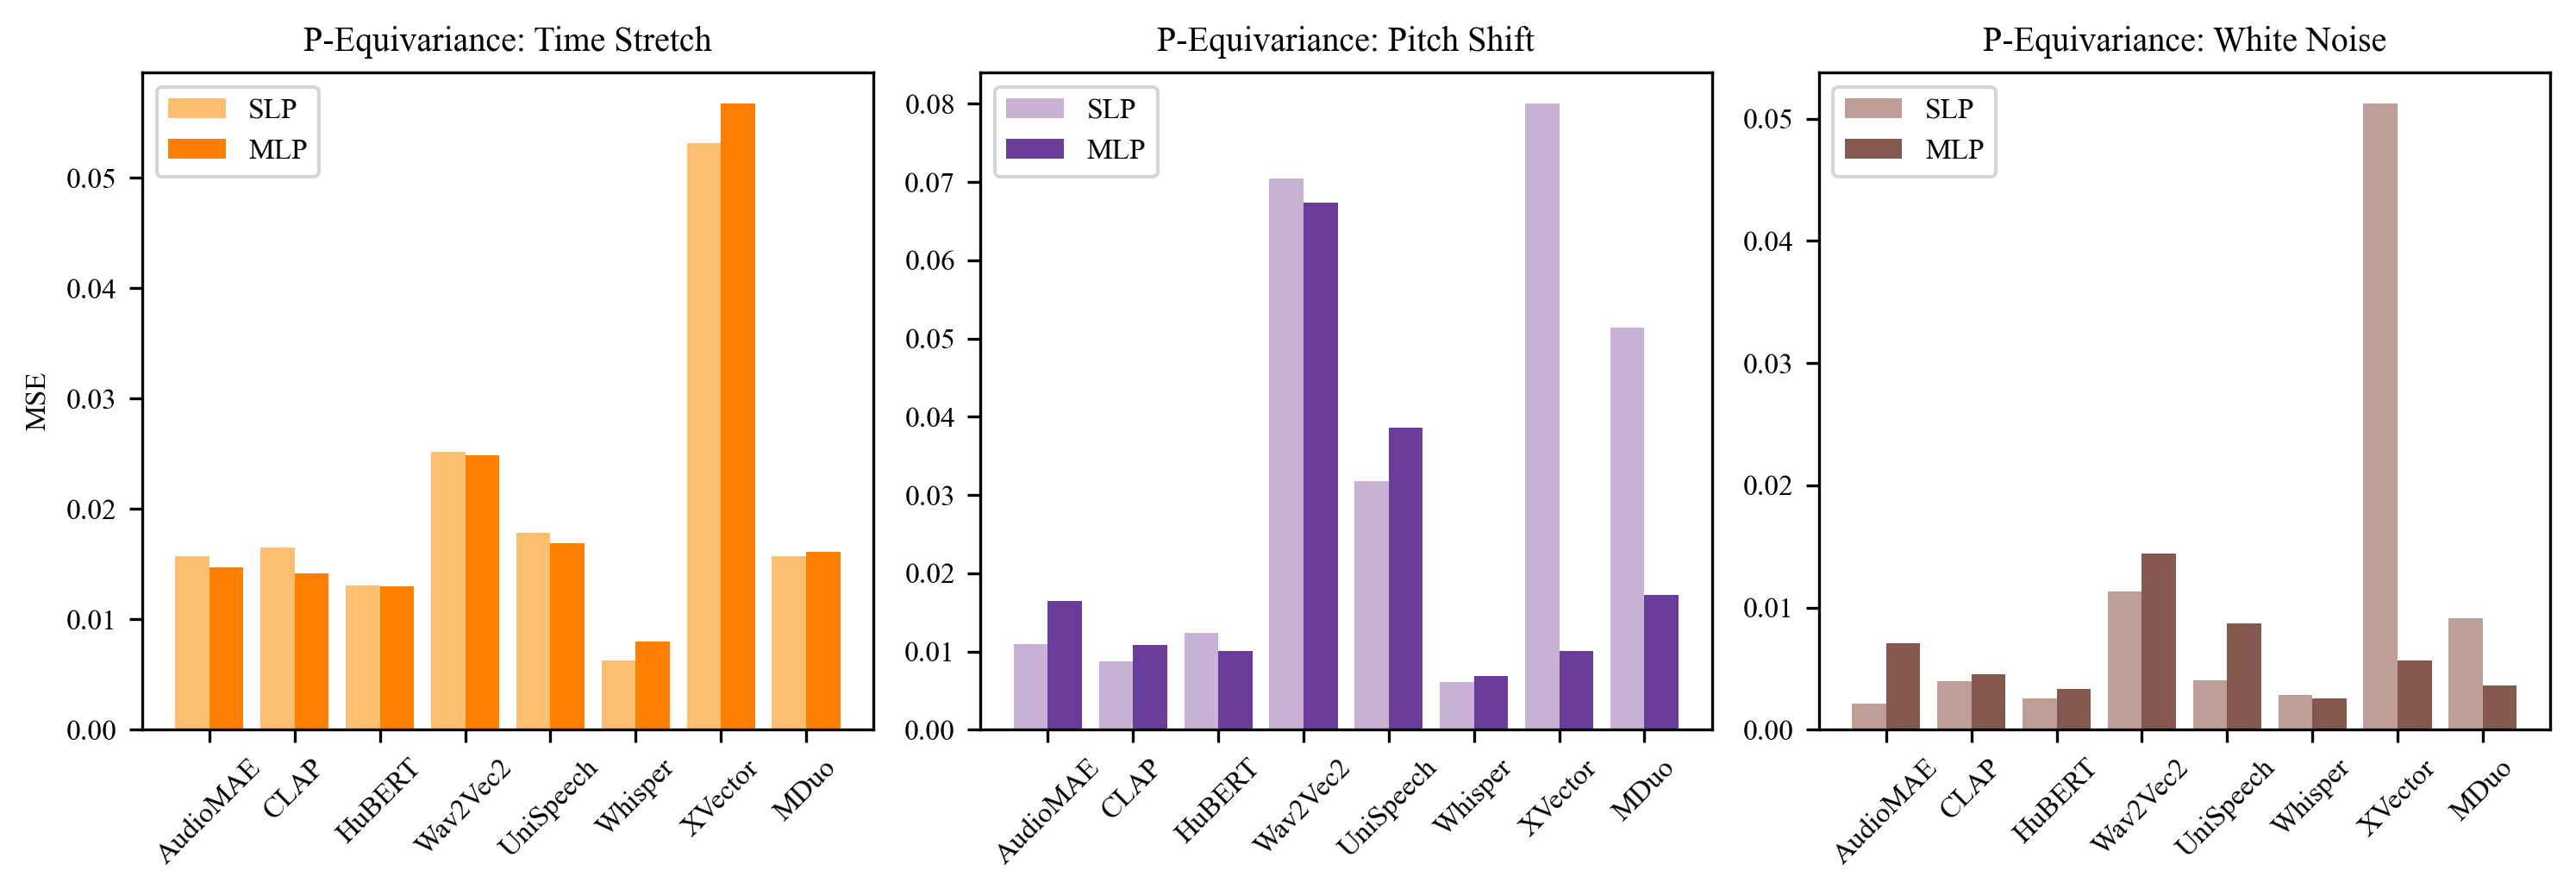

In [ ]:
nonlinear_transforms = ["TimeStretch", "PitchShift", "AddWhiteNoise"]

# Combine linear and nonlinear EQUI_PARA results with a new 'Type' column.
df_para_combined = pd.concat(
    [df_para_linear.assign(Type="Linear"), df_para_nonlinear.assign(Type="Nonlinear")]
)

# Map original transform names to display titles.
title_map = {
    "PitchShift": "Pitch Shift",
    "TimeStretch": "Time Stretch",
    "AddWhiteNoise": "White Noise",
}

# Get the Paired colormap and define a mapping from transform to a color index.
cmap = plt.get_cmap("Paired")
bar_width = 0.4
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))

for i, transform in enumerate(nonlinear_transforms):
    data = df_para_combined[df_para_combined["Transform"] == transform]
    pivot = data.pivot(index="Feature", columns="Type", values="MSE")
    pivot = pivot.reindex(feature_order)

    x = np.arange(len(pivot.index))
    linear_color = (
        cmap(6 + (i * 2))
        if (6 + (i * 2)) != 10
        else (190 / 255.0, 158 / 255.0, 150 / 255.0, 1.0)
    )
    nonlinear_color = (
        cmap(6 + (i * 2 + 1))
        if (6 + (i * 2 + 1)) != 11
        else (132 / 255.0, 88 / 255.0, 78 / 255.0, 1.0)
    )

    axes[i].bar(
        x - bar_width / 2,
        pivot["Linear"],
        width=bar_width,
        color=linear_color,
        label="SLP",
    )
    axes[i].bar(
        x + bar_width / 2,
        pivot["Nonlinear"],
        width=bar_width,
        color=nonlinear_color,
        label="MLP",
    )

    axes[i].set_title(f"P-Equivariance: {title_map[transform]}")
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(pivot.index, rotation=45)
    if i == 0:
        axes[i].set_ylabel("MSE")
    else:
        axes[i].set_ylabel("")
    axes[i].legend(loc="upper left")

plt.tight_layout()
plt.show()

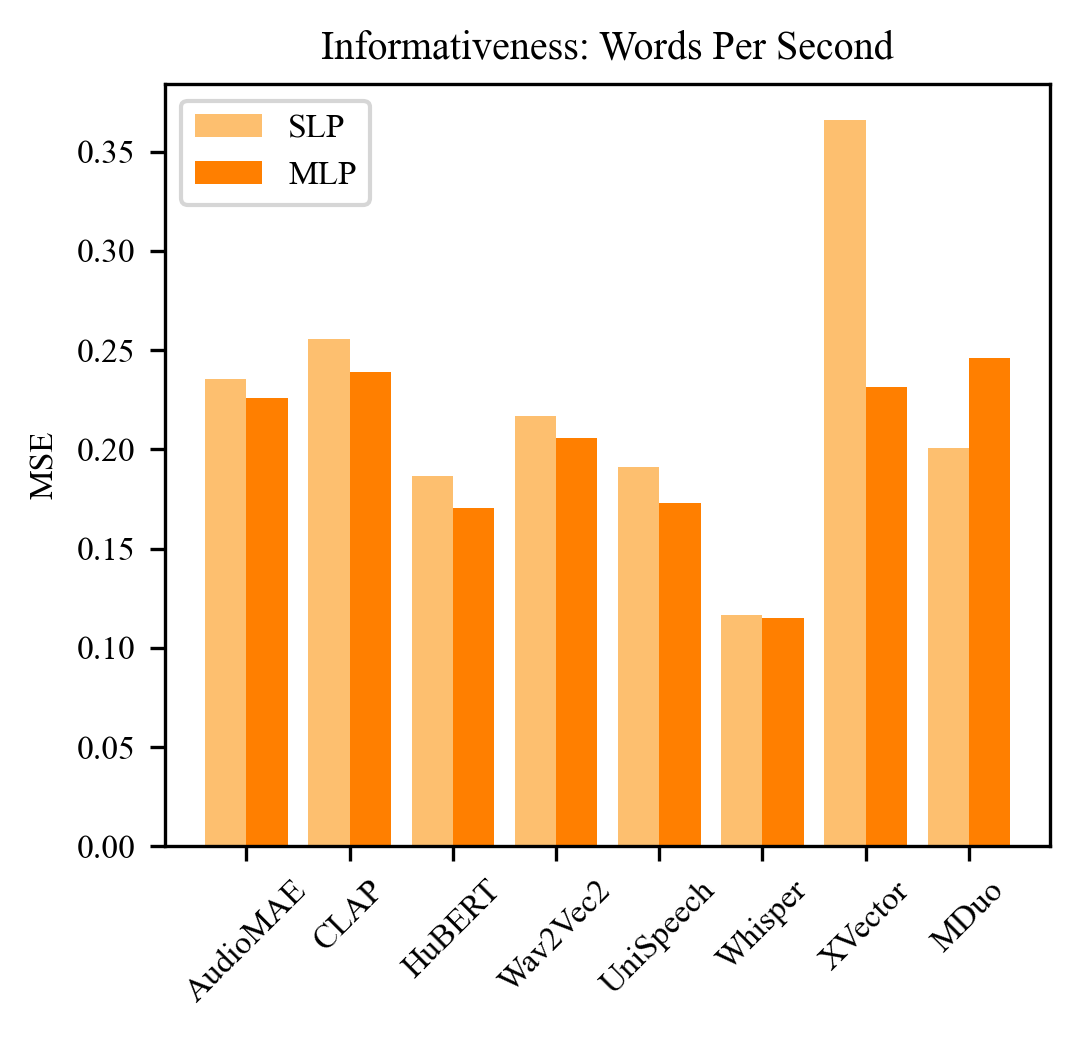

In [ ]:
# Create a combined INFO_DOWN dataframe with a new 'Type' column.
df_info_nonlinear["Type"] = "MLP"
df_info_linear["Type"] = "SLP"
df_info_combined = pd.concat([df_info_nonlinear, df_info_linear])

# Pivot the data so each feature has both SLP and MLP MSE values.
pivot = df_info_combined.pivot(index="Feature", columns="Type", values="MSE")
pivot = pivot.reindex(feature_order)

import numpy as np

# Use the Paired colormap from matplotlib
cmap = plt.get_cmap("Paired")
colors_info = {"SLP": cmap(6), "MLP": cmap(7)}

x = np.arange(len(pivot.index))
bar_width = 0.4

fig, ax = plt.subplots(figsize=(10 * 2.6 / 7.14, 3.5))
ax.bar(
    x - bar_width / 2,
    pivot["SLP"],
    width=bar_width,
    color=colors_info["SLP"],
    label="SLP",
)
ax.bar(
    x + bar_width / 2,
    pivot["MLP"],
    width=bar_width,
    color=colors_info["MLP"],
    label="MLP",
)

ax.set_xticks(x)
ax.set_xticklabels(pivot.index, rotation=45)
ax.set_ylabel("MSE")
ax.set_title("Informativeness: Words Per Second")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

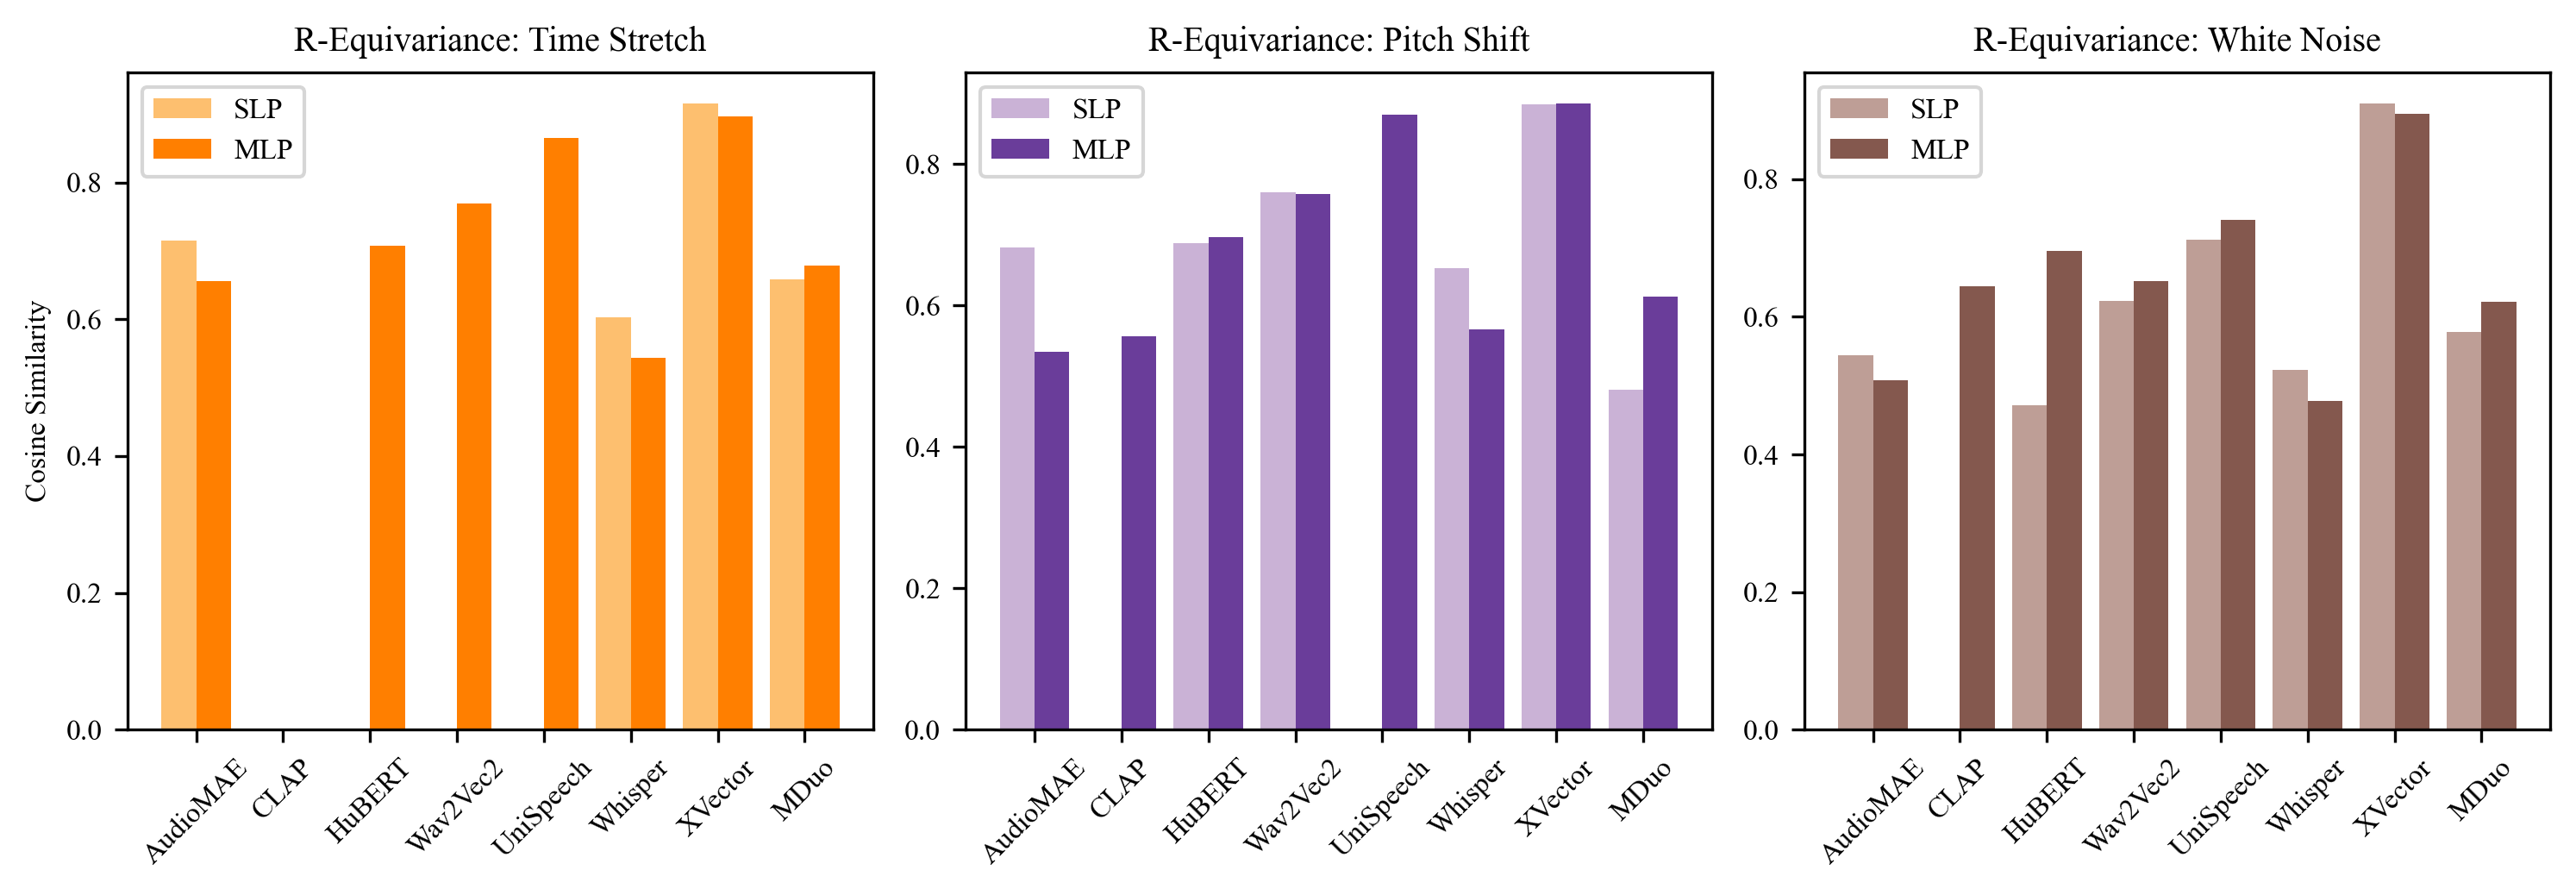

In [23]:
# ----- EQUI_FEAT Combined Plot (Main Visualization using Cosine metric) -----
# Create cosine data for EQUI_FEAT from results
feat_cosine_data = {"linear": [], "nonlinear": []}
for run_name, metrics in results.items():
    if "EQUI_FEAT_regression_" in run_name:
        feature = next((f for f in feature_order if f in run_name), None)
        transform = next(
            t for t in ["PitchShift", "TimeStretch", "AddWhiteNoise"] if t in run_name
        )
        # Use cosine metric from results
        cosine_val = metrics["cosine"]
        if "linear" in run_name:
            feat_cosine_data["linear"].append(
                {"Feature": feature, "Transform": transform, "Cosine": cosine_val}
            )
        else:
            feat_cosine_data["nonlinear"].append(
                {"Feature": feature, "Transform": transform, "Cosine": cosine_val}
            )

df_feat_cosine_linear = pd.DataFrame(feat_cosine_data["linear"])
df_feat_cosine_nonlinear = pd.DataFrame(feat_cosine_data["nonlinear"])

# Mark each probe type
df_feat_cosine_linear["Type"] = "SLP"
df_feat_cosine_nonlinear["Type"] = "MLP"
df_feat_cosine_combined = pd.concat([df_feat_cosine_linear, df_feat_cosine_nonlinear])

# Define features to plot (all LibriSpeech features)
features_to_plot = [
    "AudioMAE",
    "CLAP",
    "HuBERT",
    "Wav2Vec2",
    "UniSpeech",
    "Whisper",
    "XVector",
    "MDuo",
]

# Define transform order
transforms = ["TimeStretch", "PitchShift", "AddWhiteNoise"]

# Create the visualization
cmap = plt.get_cmap("Paired")
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))

for i, transform in enumerate(transforms):
    df_trans = df_feat_cosine_combined[
        df_feat_cosine_combined["Transform"] == transform
    ]
    pivot = df_trans.pivot_table(
        index="Feature", columns="Type", values="Cosine", aggfunc="mean"
    )
    pivot = pivot.reindex(features_to_plot)
    x = np.arange(len(pivot.index))
    bar_width = 0.4

    color_slp = (
        cmap(6 + (i * 2))
        if (6 + (i * 2)) != 10
        else (190 / 255.0, 158 / 255.0, 150 / 255.0, 1.0)
    )
    color_mlp = (
        cmap(6 + (i * 2 + 1))
        if (6 + (i * 2 + 1)) != 11
        else (132 / 255.0, 88 / 255.0, 78 / 255.0, 1.0)
    )

    axes[i].bar(
        x - bar_width / 2, pivot["SLP"], width=bar_width, color=color_slp, label="SLP"
    )
    axes[i].bar(
        x + bar_width / 2, pivot["MLP"], width=bar_width, color=color_mlp, label="MLP"
    )

    axes[i].set_xticks(x)
    axes[i].set_xticklabels(pivot.index, rotation=45)

    # Map transform names to display titles
    title_map = {
        "PitchShift": "Pitch Shift",
        "TimeStretch": "Time Stretch",
        "AddWhiteNoise": "White Noise",
    }
    axes[i].set_title(f"R-Equivariance: {title_map[transform]}")

    if i == 0:
        axes[i].set_ylabel("Cosine Similarity")
    axes[i].legend(loc="upper left")

plt.tight_layout()
plt.show()